In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pandas as pd
import random

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

In [2]:
path = "/Users/muhammadhussain/Desktop/Data/filter/finished.parquet"
df = pd.read_parquet(path)
data = df.to_numpy()

In [3]:
evaldatatrain = pd.read_parquet(path)
evaldatatrain = evaldatatrain.drop(columns=["main_fault_0", "Type_0", "Event_0"])
evaldatatrain

,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_23,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber
0,0.485207,0.490909,0.490798,0.478528,0.466258,0.447853,0.417178,0.411043,0.392638,0.380368,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:29:05,Bad insulation,806031
1,0.479290,0.484848,0.478528,0.466258,0.447853,0.417178,0.411043,0.392638,0.380368,0.374233,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:30:05,Bad insulation,806031
2,0.473373,0.472727,0.466258,0.447853,0.417178,0.411043,0.392638,0.380368,0.374233,0.368098,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:31:05,Bad insulation,806031
3,0.461538,0.460606,0.447853,0.417178,0.411043,0.392638,0.380368,0.374233,0.368098,0.368098,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:32:05,Bad insulation,806031
4,0.449704,0.442424,0.417178,0.411043,0.392638,0.380368,0.374233,0.368098,0.368098,0.374233,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:33:05,Bad insulation,806031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76503,0.473373,0.472727,0.460123,0.429448,0.398773,0.380368,0.361963,0.361963,0.368098,0.386503,...,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013-02-25 02:51:12,None,806278
76504,0.461538,0.454545,0.429448,0.398773,0.380368,0.361963,0.361963,0.368098,0.386503,0.404908,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,2013-02-25 02:52:12,None,806278
76505,0.443787,0.424242,0.398773,0.380368,0.361963,0.361963,0.368098,0.386503,0.404908,0.411043,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.052632,2013-02-25 02:53:12,None,806278
76506,0.414201,0.393939,0.380368,0.361963,0.361963,0.368098,0.386503,0.404908,0.411043,0.441718,...,0.000000,0.000000,0.000000,0.000000,0.052632,0.052632,0.157895,2013-02-25 02:54:12,None,806278


In [4]:
evaldatatrain["main_fault"].unique()

array(['Bad insulation', 'Electrical malfunction', 'Refrigerant leakage',
       '1st stage compressor', 'High condensation', 'Door tightness',
       'Wrong setpoint', '2nd stage compressor', 'Unstable operation',
       'None'], dtype=object)

In [5]:
# Hardcoded mapping for each string to a specific numeric value
fault_mapping = {
    'None': 0,
    'Electrical malfunction': 1,
    'Refrigerant leakage': 2,
    '1st stage compressor': 3,
    'High condensation': 4,
    'Door tightness': 5,
    'Wrong setpoint': 6,
    '2nd stage compressor': 7,
    'Unstable operation': 8,
    "Bad insulation": 9
}

# Replace NaN with "None"
evaldatatrain['main_fault'] = evaldatatrain['main_fault'].fillna('None')

# Map each string to its corresponding numeric value
evaldatatrain['main_fault_numeric'] = evaldatatrain['main_fault'].map(fault_mapping)

# Hvis der findes værdier, der ikke er i fault_mapping, kan du evt. håndtere dem:
# evaldatatrain['main_fault_numeric'] = evaldatatrain['main_fault_numeric'].fillna(-1)

evaldatatrain


,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber,main_fault_numeric
0,0.485207,0.490909,0.490798,0.478528,0.466258,0.447853,0.417178,0.411043,0.392638,0.380368,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:29:05,Bad insulation,806031,9
1,0.479290,0.484848,0.478528,0.466258,0.447853,0.417178,0.411043,0.392638,0.380368,0.374233,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:30:05,Bad insulation,806031,9
2,0.473373,0.472727,0.466258,0.447853,0.417178,0.411043,0.392638,0.380368,0.374233,0.368098,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:31:05,Bad insulation,806031,9
3,0.461538,0.460606,0.447853,0.417178,0.411043,0.392638,0.380368,0.374233,0.368098,0.368098,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:32:05,Bad insulation,806031,9
4,0.449704,0.442424,0.417178,0.411043,0.392638,0.380368,0.374233,0.368098,0.368098,0.374233,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:33:05,Bad insulation,806031,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76503,0.473373,0.472727,0.460123,0.429448,0.398773,0.380368,0.361963,0.361963,0.368098,0.386503,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013-02-25 02:51:12,None,806278,0
76504,0.461538,0.454545,0.429448,0.398773,0.380368,0.361963,0.361963,0.368098,0.386503,0.404908,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,2013-02-25 02:52:12,None,806278,0
76505,0.443787,0.424242,0.398773,0.380368,0.361963,0.361963,0.368098,0.386503,0.404908,0.411043,...,0.000000,0.000000,0.000000,0.000000,0.052632,0.052632,2013-02-25 02:53:12,None,806278,0
76506,0.414201,0.393939,0.380368,0.361963,0.361963,0.368098,0.386503,0.404908,0.411043,0.441718,...,0.000000,0.000000,0.000000,0.052632,0.052632,0.157895,2013-02-25 02:54:12,None,806278,0


In [6]:
# Get unique pairs of main_fault and main_fault_numeric
unique_pairs = evaldatatrain[['main_fault', 'main_fault_numeric']].drop_duplicates().sort_values(by='main_fault_numeric')

# Print the mapping
print("Mapping of strings to numbers:")
for index, row in unique_pairs.iterrows():
    print(f"{row['main_fault_numeric']}: {row['main_fault']}")

Mapping of strings to numbers:
0: None
1: Electrical malfunction
2: Refrigerant leakage
3: 1st stage compressor
4: High condensation
5: Door tightness
6: Wrong setpoint
7: 2nd stage compressor
8: Unstable operation
9: Bad insulation


In [7]:
evaldatatrain["main_fault_numeric"].unique()

array([9, 1, 2, 3, 4, 5, 6, 7, 8, 0])

In [8]:
from sklearn.model_selection import train_test_split
import torch

# Definer input og output
inp = evaldatatrain.drop(columns=["Datetime", "main_fault", "seriesnumber", "main_fault_numeric"])
time = evaldatatrain["Datetime"]
out = evaldatatrain["main_fault_numeric"]
seriesnumber = evaldatatrain["seriesnumber"]

import pandas as pd
import torch

# Sorter datasættet efter 'seriesnumber' og 'Datetime'
evaldatatrain_sorted = evaldatatrain.sort_values(by=["seriesnumber", "Datetime"])

# Liste til at gemme træning og validering data
train_data = []
valid_data = []

# Iterer over hver unik 'seriesnumber'
for series in evaldatatrain_sorted["seriesnumber"].unique():
    series_data = evaldatatrain_sorted[evaldatatrain_sorted["seriesnumber"] == series]
    
    # Start iteration for hver main_fault_numeric
    current_main_fault = None
    fault_group = []
    
    for _, row in series_data.iterrows():
        if row["main_fault_numeric"] != current_main_fault:
            # Hvis der er en gruppe, splittes den
            if fault_group:
                # Split i træning (80%) og validering (20%)
                split_idx = int(len(fault_group) * 0.8)
                train_data.extend(fault_group[:split_idx])
                valid_data.extend(fault_group[split_idx:])
            
            # Start en ny gruppe
            current_main_fault = row["main_fault_numeric"]
            fault_group = []
        
        # Tilføj rækken til gruppen
        fault_group.append(row)
    
    # Håndter sidste gruppe
    if fault_group:
        split_idx = int(len(fault_group) * 0.8)
        train_data.extend(fault_group[:split_idx])
        valid_data.extend(fault_group[split_idx:])

# Konverter træning og validering data til DataFrames
train_df = pd.DataFrame(train_data)
valid_df = pd.DataFrame(valid_data)

# Definer input og output
x_train = torch.tensor(train_df.drop(columns=["Datetime", "main_fault", "seriesnumber", "main_fault_numeric"]).values, dtype=torch.float32)
x_valid = torch.tensor(valid_df.drop(columns=["Datetime", "main_fault", "seriesnumber", "main_fault_numeric"]).values, dtype=torch.float32)


targets_train = torch.tensor(train_df["main_fault_numeric"].values, dtype=torch.int64)
targets_valid = torch.tensor(valid_df["main_fault_numeric"].values, dtype=torch.int64)


# Lav også tids- og seriesnummerlister for senere analyse
time_train = train_df["Datetime"].reset_index(drop=True)
time_valid = valid_df["Datetime"].reset_index(drop=True)

series_train = train_df["seriesnumber"].reset_index(drop=True)
series_valid = valid_df["seriesnumber"].reset_index(drop=True)

# Bekræft fordelingen
print("Train target distribution:", train_df["main_fault_numeric"].value_counts().to_dict())
print("Valid target distribution:", valid_df["main_fault_numeric"].value_counts().to_dict())


Train target distribution: {3: 13655, 8: 6843, 1: 6842, 7: 6817, 5: 6678, 0: 5564, 2: 4548, 9: 3433, 6: 3409, 4: 3409}
Valid target distribution: {3: 3415, 1: 1712, 8: 1711, 7: 1706, 5: 1671, 0: 1391, 2: 1139, 9: 859, 6: 853, 4: 853}


In [9]:
# To speed up training we'll only work on a subset of the data
#x_train = inp[:round(len(inp)/3)]
#targets_train = out[:round(len(inp)/3)]

#x_valid = inp[round(len(inp)/3):round(2*len(inp)/3)]
#targets_valid = out[round(len(inp)/3):round(2*len(inp)/3)]

#x_test = inp[round(2*len(inp)/3):]
#targets_test = out[round(2*len(inp)/3):]

#from sklearn.model_selection import train_test_split
#import torch

#x_train = inp[:1000]
#targets_train = out[:1000]

#x_valid = inp[1000:2000]
#targets_valid = out[1000:2000]

#x_test = inp[2000:3000]
#targets_test = out[2000:3000]


print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)

Information on dataset
x_train torch.Size([61198, 360])
targets_train torch.Size([61198])
x_valid torch.Size([15310, 360])
targets_valid torch.Size([15310])


In [10]:
x_train.shape[1]

360

In [11]:
# Hyperparameters
num_classes = 10
num_l1 = 32  # Size of the first hidden layer
num_l2 = 16  # Size of the second hidden layer
num_l3 = 8   # Size of the third hidden layer
num_features = x_train.shape[1]
sequence_length = 30  # Number of features per sequence
num_sequences = num_features // sequence_length  # Number of sequences

# Ensure input features are divisible by sequence length
assert num_features % sequence_length == 0, "Total number of features must be divisible by the sequence length."

# Define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1, num_hidden2, num_hidden3, num_output):
        super(Net, self).__init__()

        # Create one LSTM for each feature
        self.rnn_layers = nn.ModuleList([
            nn.LSTM(input_size=sequence_length, hidden_size=16, batch_first=True)
            for _ in range(num_sequences)
        ])

        # Input layer
        self.W_1 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden1, num_sequences * 16)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))

        # Hidden layer 1
        self.W_2 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))

        # Hidden layer 2
        self.W_3 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden3, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_hidden3), 0))

        # Output layer
        self.W_4 = Parameter(init.kaiming_uniform_(torch.Tensor(num_output, num_hidden3)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(num_output), 0))

        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        # Reshape input into (batch_size, num_sequences, sequence_length)
        batch_size = x.size(0)
        x = x.view(batch_size, num_sequences, sequence_length)

        # Process each sequence with its respective RNN
        rnn_outputs = []
        for i, rnn in enumerate(self.rnn_layers):
            sequence_input = x[:, i, :].unsqueeze(1)  # Extract sequence for this feature
            rnn_out, _ = rnn(sequence_input)  # rnn_out shape: (batch_size, 1, hidden_size)
            rnn_outputs.append(rnn_out[:, -1, :])  # Take the last hidden state

        # Concatenate outputs from all RNNs
        x = torch.cat(rnn_outputs, dim=1)  # Shape: (batch_size, num_sequences * hidden_size)

        # Input layer
        x = self.dropout(x)
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)

        # Hidden layer 1
        x = self.dropout(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)

        # Hidden layer 2
        x = self.dropout(x)
        x = F.linear(x, self.W_3, self.b_3)
        x = self.activation(x)

        # Output layer
        x = F.linear(x, self.W_4, self.b_4)

        return x

# Initialize the network
net = Net(num_features, num_l1, num_l2, num_l3, num_classes)


In [12]:
# setting up parameters for wheights
targets = targets_train # Klasseindeks for observationer

# Beregn forekomsten af hver klasse
num_classes = torch.max(targets) + 1
class_counts = torch.bincount(targets, minlength=num_classes)

# Beregn vægtene som den inverse af forekomsten
weights = 1.0 / class_counts
weights = weights / weights.sum()  # Normaliser vægtene


In [42]:
print("Class weights:", weights)


Class weights: tensor([0.0927, 0.0754, 0.1134, 0.0378, 0.1512, 0.0772, 0.1512, 0.0756, 0.0753,
        0.1502])


Inbalanced/Unbalanced

In [13]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss(weight=weights)

wheightedcrossentroptyloss.

Epoch  1 : Train Loss 6.801107 , Train acc 0.112072, Valid acc 0.111895
Epoch 11 : Train Loss 6.340838 , Train acc 0.223669, Valid acc 0.223203
Epoch 21 : Train Loss 6.378403 , Train acc 0.223669, Valid acc 0.223203
Epoch 31 : Train Loss 6.322414 , Train acc 0.223669, Valid acc 0.223203
Epoch 41 : Train Loss 5.837565 , Train acc 0.223669, Valid acc 0.223203
Epoch 51 : Train Loss 6.322631 , Train acc 0.223669, Valid acc 0.223203
Epoch 61 : Train Loss 6.322633 , Train acc 0.223669, Valid acc 0.223203
Epoch 71 : Train Loss 5.808459 , Train acc 0.112072, Valid acc 0.111895
Epoch 81 : Train Loss 4.764167 , Train acc 0.112072, Valid acc 0.111895
Epoch 91 : Train Loss 6.306642 , Train acc 0.109238, Valid acc 0.110850
Model saved to trained_modelFFNN.pth


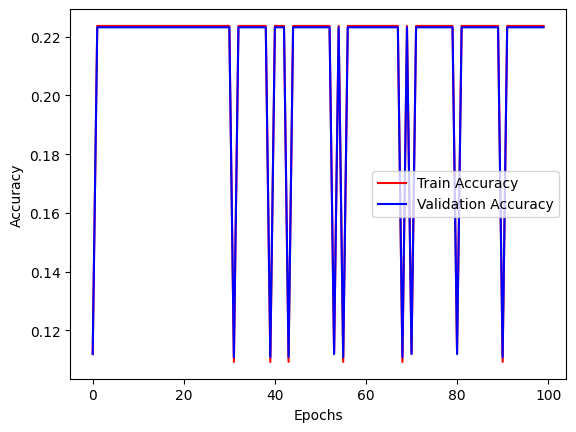

In [14]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score
import torch
import numpy as np
import matplotlib.pyplot as plt

# setting hyperparameters and getting epoch sizes
batch_size = 150
num_epochs = 100
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size


# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprop -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

# Save the model's parameters
model_path = "trained_modelFFNN.pth"
torch.save(net.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot accuracy
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs'), plt.ylabel('Accuracy')
plt.show()


In [16]:
# Indlæs modellen
num_classes = 10 
num_l1 = 32  # Increased size of the first hidden layer
num_l2 = 16  # Added a second hidden layer
num_l3 = 8   # Added a third hidden layer
num_features = x_train.shape[1]


net_loaded = Net(num_features, num_l1,num_l2,num_l3  ,num_classes)  # Sørg for at bruge samme arkitektur
net_loaded.load_state_dict(torch.load(model_path))
net_loaded.eval()  # Sæt modellen i evalueringsmodus

print("Model loaded successfully!")


Model loaded successfully!


In [17]:
net.eval()

Net(
  (rnn_layers): ModuleList(
    (0-11): 12 x LSTM(30, 16, batch_first=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): ReLU()
)

In [18]:
# Inspect the state dictionary
for name, param in net_loaded.state_dict().items():
    print(f"{name}: {param.shape}")

W_1: torch.Size([32, 192])
b_1: torch.Size([32])
W_2: torch.Size([16, 32])
b_2: torch.Size([16])
W_3: torch.Size([8, 16])
b_3: torch.Size([8])
W_4: torch.Size([10, 8])
b_4: torch.Size([10])
rnn_layers.0.weight_ih_l0: torch.Size([64, 30])
rnn_layers.0.weight_hh_l0: torch.Size([64, 16])
rnn_layers.0.bias_ih_l0: torch.Size([64])
rnn_layers.0.bias_hh_l0: torch.Size([64])
rnn_layers.1.weight_ih_l0: torch.Size([64, 30])
rnn_layers.1.weight_hh_l0: torch.Size([64, 16])
rnn_layers.1.bias_ih_l0: torch.Size([64])
rnn_layers.1.bias_hh_l0: torch.Size([64])
rnn_layers.2.weight_ih_l0: torch.Size([64, 30])
rnn_layers.2.weight_hh_l0: torch.Size([64, 16])
rnn_layers.2.bias_ih_l0: torch.Size([64])
rnn_layers.2.bias_hh_l0: torch.Size([64])
rnn_layers.3.weight_ih_l0: torch.Size([64, 30])
rnn_layers.3.weight_hh_l0: torch.Size([64, 16])
rnn_layers.3.bias_ih_l0: torch.Size([64])
rnn_layers.3.bias_hh_l0: torch.Size([64])
rnn_layers.4.weight_ih_l0: torch.Size([64, 30])
rnn_layers.4.weight_hh_l0: torch.Size([64,

In [19]:
output = net(x_valid)
output

tensor([[-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131],
        [-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131],
        [-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131],
        ...,
        [-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131],
        [-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131],
        [-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131]],
       grad_fn=<AddmmBackward0>)

In [20]:
predictedclass = torch.argmax(output, dim=1)
predictedclass

tensor([3, 3, 3,  ..., 3, 3, 3])

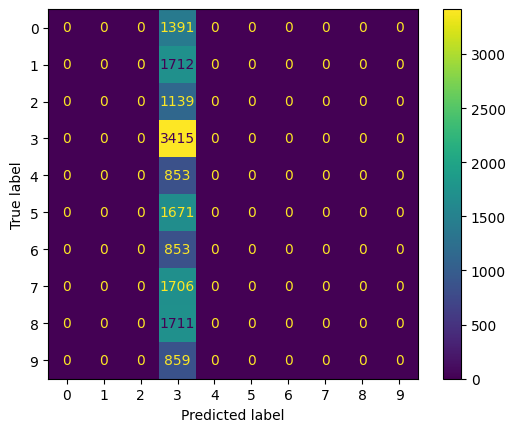

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


predictedclass = torch.argmax(net(x_valid), dim=1)

cm = confusion_matrix(targets_valid, predictedclass)
ConfusionMatrixDisplay(cm).plot()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(targets_valid, predictedclass)
precision = precision_score(targets_valid, predictedclass, average='weighted')
recall = recall_score(targets_valid, predictedclass, average='weighted')
f1 = f1_score(targets_valid, predictedclass, average='weighted')


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", precision)
print("f1:", precision)

Accuracy: 0.22305682560418028
Precision: 0.04975434744861369
Recall: 0.04975434744861369
f1: 0.04975434744861369


/opt/anaconda3/envs/[neuralnetwork]/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
targets_valid.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [24]:
predictedclass.unique()

tensor([3])

In [25]:
binarypredictedclass = [1 if i > 0 else 0 for i in predictedclass]
binarytargets_test = [1 if i > 0 else 0 for i in targets_valid]

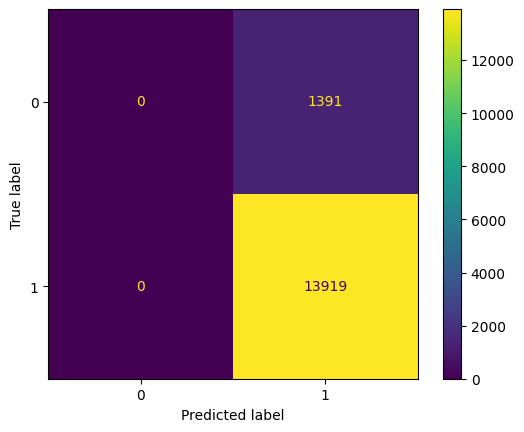

In [26]:
cm = confusion_matrix(binarytargets_test, binarypredictedclass)
ConfusionMatrixDisplay(cm).plot()

In [27]:
unique_values, counts = torch.unique(targets_train, return_counts=True)

print("Unikke værdier:", unique_values)
print("Hyppigheder:", counts)

Unikke værdier: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Hyppigheder: tensor([ 5564,  6842,  4548, 13655,  3409,  6678,  3409,  6817,  6843,  3433])


Test model for unseen data.

In [28]:
path = "/Users/muhammadhussain/Desktop/Data/filter/excluded.parquet"
df = pd.read_parquet(path)
data = df.to_numpy()

In [29]:
evaldatatrain = pd.read_parquet(path)
evaldatatrain = evaldatatrain.drop(columns=["main_fault_0", "Type_0", "Event_0"])
evaldatatrain

,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_23,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber
0,0.455090,0.475309,0.500000,0.516556,0.577778,0.614173,0.647541,0.681034,0.672414,0.655172,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,2015-03-16 12:29:12,Refrigerant leakage,806017
1,0.461078,0.481481,0.500000,0.516556,0.577778,0.622047,0.647541,0.672414,0.655172,0.620690,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,2015-03-16 12:30:12,Refrigerant leakage,806017
2,0.467066,0.481481,0.500000,0.516556,0.585185,0.622047,0.639344,0.655172,0.620690,0.551724,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,2015-03-16 12:31:12,Refrigerant leakage,806017
3,0.467066,0.481481,0.500000,0.523179,0.585185,0.614173,0.622951,0.620690,0.551724,0.508621,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,2015-03-16 12:32:12,Refrigerant leakage,806017
4,0.467066,0.481481,0.506410,0.523179,0.577778,0.598425,0.590164,0.551724,0.508621,0.491379,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,2015-03-16 12:33:12,Refrigerant leakage,806017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41967,0.461078,0.462963,0.455128,0.437086,0.459259,0.456693,0.467213,0.500000,0.517241,0.543103,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,2013-02-22 22:31:12,None,806278
41968,0.449102,0.438272,0.423077,0.410596,0.429630,0.448819,0.475410,0.517241,0.543103,0.560345,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,2013-02-22 22:32:12,None,806278
41969,0.425150,0.407407,0.397436,0.384106,0.422222,0.456693,0.491803,0.543103,0.560345,0.594828,...,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.428571,2013-02-22 22:33:12,None,806278
41970,0.395210,0.382716,0.371795,0.377483,0.429630,0.472441,0.516393,0.560345,0.594828,0.620690,...,0.000000,0.000000,0.000000,0.142857,0.142857,0.428571,0.428571,2013-02-22 22:34:12,None,806278


In [30]:
evaldatatrain["main_fault"].unique()

array(['Refrigerant leakage', 'High condensation', 'Unstable operation',
       '2nd stage compressor', 'Electrical malfunction', 'None'],
      dtype=object)

In [31]:
# Hardcoded mapping for each string to a specific numeric value
fault_mapping = {
    'None': 0,
    'Electrical malfunction': 1,
    'Refrigerant leakage': 2,
    '1st stage compressor': 3,
    'High condensation': 4,
    'Door tightness': 5,
    'Wrong setpoint': 6,
    '2nd stage compressor': 7,
    'Unstable operation': 8,
}

# Replace NaN with "None"
evaldatatrain['main_fault'] = evaldatatrain['main_fault'].fillna('None')

# Map each string to its corresponding numeric value
evaldatatrain['main_fault_numeric'] = evaldatatrain['main_fault'].map(fault_mapping)

# Hvis der findes værdier, der ikke er i fault_mapping, kan du evt. håndtere dem:
# evaldatatrain['main_fault_numeric'] = evaldatatrain['main_fault_numeric'].fillna(-1)

evaldatatrain


,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber,main_fault_numeric
0,0.455090,0.475309,0.500000,0.516556,0.577778,0.614173,0.647541,0.681034,0.672414,0.655172,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,2015-03-16 12:29:12,Refrigerant leakage,806017,2
1,0.461078,0.481481,0.500000,0.516556,0.577778,0.622047,0.647541,0.672414,0.655172,0.620690,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,2015-03-16 12:30:12,Refrigerant leakage,806017,2
2,0.467066,0.481481,0.500000,0.516556,0.585185,0.622047,0.639344,0.655172,0.620690,0.551724,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,2015-03-16 12:31:12,Refrigerant leakage,806017,2
3,0.467066,0.481481,0.500000,0.523179,0.585185,0.614173,0.622951,0.620690,0.551724,0.508621,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,2015-03-16 12:32:12,Refrigerant leakage,806017,2
4,0.467066,0.481481,0.506410,0.523179,0.577778,0.598425,0.590164,0.551724,0.508621,0.491379,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,2015-03-16 12:33:12,Refrigerant leakage,806017,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41967,0.461078,0.462963,0.455128,0.437086,0.459259,0.456693,0.467213,0.500000,0.517241,0.543103,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,2013-02-22 22:31:12,None,806278,0
41968,0.449102,0.438272,0.423077,0.410596,0.429630,0.448819,0.475410,0.517241,0.543103,0.560345,...,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,2013-02-22 22:32:12,None,806278,0
41969,0.425150,0.407407,0.397436,0.384106,0.422222,0.456693,0.491803,0.543103,0.560345,0.594828,...,0.000000,0.000000,0.000000,0.142857,0.142857,0.428571,2013-02-22 22:33:12,None,806278,0
41970,0.395210,0.382716,0.371795,0.377483,0.429630,0.472441,0.516393,0.560345,0.594828,0.620690,...,0.000000,0.000000,0.142857,0.142857,0.428571,0.428571,2013-02-22 22:34:12,None,806278,0


In [32]:
evaldatatrain["main_fault_numeric"].unique()

array([2, 4, 8, 7, 1, 0])

In [33]:
# Get unique pairs of main_fault and main_fault_numeric
unique_pairs = evaldatatrain[['main_fault', 'main_fault_numeric']].drop_duplicates().sort_values(by='main_fault_numeric')

# Print the mapping
print("Mapping of strings to numbers:")
for index, row in unique_pairs.iterrows():
    print(f"{row['main_fault_numeric']}: {row['main_fault']}")

Mapping of strings to numbers:
0: None
1: Electrical malfunction
2: Refrigerant leakage
4: High condensation
7: 2nd stage compressor
8: Unstable operation


In [34]:
inp = evaldatatrain.drop(columns=["Datetime", "main_fault", "seriesnumber", "main_fault_numeric"])
time = evaldatatrain["Datetime"]
out = evaldatatrain["main_fault_numeric"]
seriesnumber = evaldatatrain["seriesnumber"]

In [35]:
x_test = torch.tensor(inp.values, dtype=torch.float32)
targets_test = torch.tensor(out.values, dtype=torch.int64)

In [36]:
output = net(x_test)
output

tensor([[-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131],
        [-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131],
        [-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131],
        ...,
        [-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131],
        [-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131],
        [-0.4887,  0.0781, -0.2859,  ...,  0.1902, -0.4342, -0.5131]],
       grad_fn=<AddmmBackward0>)

In [37]:
predictedclass = torch.argmax(output, dim=1)
predictedclass

tensor([3, 3, 3,  ..., 3, 3, 3])

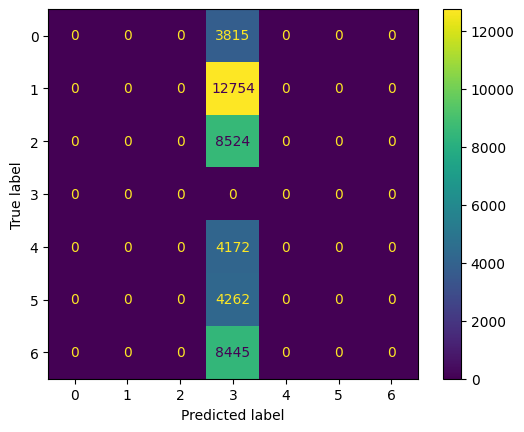

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


predictedclass = torch.argmax(net(x_test), dim=1)

cm = confusion_matrix(targets_test, predictedclass)
ConfusionMatrixDisplay(cm).plot()

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(targets_test, predictedclass)
precision = precision_score(targets_test, predictedclass, average='weighted')
recall = recall_score(targets_test, predictedclass, average='weighted')
f1 = f1_score(targets_test, predictedclass, average='weighted')


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", precision)
print("f1:", precision)

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
f1: 0.0


/opt/anaconda3/envs/[neuralnetwork]/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/[neuralnetwork]/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
binarypredictedclass = [1 if i > 0 else 0 for i in predictedclass]
binarytargets_test = [1 if i > 0 else 0 for i in targets_test]

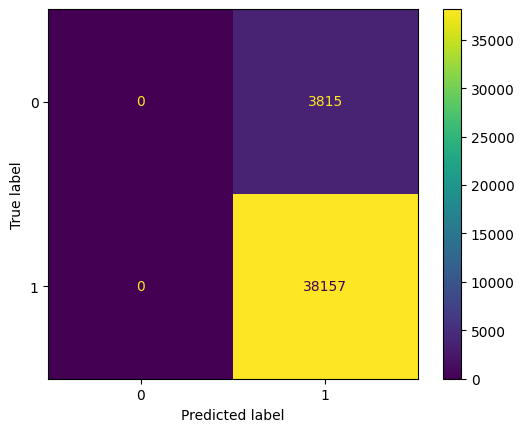

In [41]:
cm = confusion_matrix(binarytargets_test, binarypredictedclass)
ConfusionMatrixDisplay(cm).plot()